In [1]:
import sys
# sys.path.insert(0, '/raum_raid/rakhil.immidisetti/code/ssl_hdr/JupiterCVML/europa/base/src/europa')

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import matplotlib as mpl
classlabels_viz_colors = ['black', 'green', 'yellow', 'blue', 'red', 'magenta', 'cyan',
                          'lightseagreen', 'brown', 'magenta', 'olive', 'wheat', 'white', 'black']
classlabels_viz_bounds = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 100]

classlabels_viz_cmap = mpl.colors.ListedColormap(classlabels_viz_colors)
classlabels_viz_cmap = mpl.colors.ListedColormap(classlabels_viz_colors)
classlabels_viz_norm = mpl.colors.BoundaryNorm(classlabels_viz_bounds, classlabels_viz_cmap.N)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def compute_metrics(false_positive = 0, false_negative = 0, true_positive = 0, true_negative = 0, **kwargs):
    if false_negative == 0 and 'large_object_false_negative' in kwargs:
        false_negative = kwargs['large_object_false_negative']
        
    if not (true_positive or false_positive):  # 0 / 0
        precision_image = np.nan
    else:
        precision_image = true_positive/(true_positive + false_positive)

    # Using nan to distinguish 0/0 from 0/(tp+fn>0) from 1 (when tp == fn + tp).
    if not (true_positive or false_negative):  # 0 / 0
        recall_image = np.nan
    else:
        recall_image = true_positive/(true_positive + false_negative)

    # Calculate f1 in terms of TP,FP,FN instead of precision,recall
    # so result does not depend on the choice of edge-case handling for precision and recall.
    # Using nan to distinguish 0/0 from 0/((tp + 0.5 * (fn + fn)) > 0)
    # from 1 (when tp > 1 and fp + fn == 0).
    if not (true_positive or false_positive or false_negative):  # 0 / 0
        f1_image = np.nan
    else:
        f1_image = true_positive / (true_positive + 0.5 * (false_positive + false_negative))

    # calculate productivity score
    if not (true_negative or false_positive):
        productivity_image = np.nan
    else:
        productivity_image = true_negative / (true_negative + false_positive)

    # print("precision_image:", precision_image)
    print("Safety score: {:.2f}".format(recall_image * 100))
    # print("f1_image:", f1_image)
    # print("productivity_image:", productivity_image)
    return "{:.2f}".format(recall_image * 100)

In [3]:
# df_iq = pd.read_csv('/raid/avinash.raju/critical_safety_2022_vehicle_v5_anno.csv')
df_iq = pd.read_csv('/raid/avinash.raju/humans_on_path_test_set_2022_v9_anno.csv')
# df_iq = pd.read_csv('/raid/avinash.raju/iq_with_half_image_check_for_linear_mode.csv')
df_iq['iq'].value_counts()

/tmp/ipykernel_180691/2047538775.py:2: DtypeWarning: Columns (148) have mixed types. Specify dtype option on import or set low_memory=False.
  df_iq = pd.read_csv('/raid/avinash.raju/humans_on_path_test_set_2022_v9_anno.csv')


good      17788
bright      723
dark        678
smudge      170
Name: iq, dtype: int64

In [12]:
df_iq[['iq', 'iq_features', 'iq_features_total', 'iq_features_sharpness', 'iq_features_smudge', 'iq_features_smudge_reason']].head()

,iq,iq_features,iq_features_total,iq_features_sharpness,iq_features_smudge,iq_features_smudge_reason
0,good,"{'confidence': 1.0, 'image_features': {'total'...",1572864,3534.817383,23.280884,not_smudged
1,good,"{'confidence': 1.0, 'image_features': {'total'...",1572864,5267.735352,24.623718,not_smudged
2,good,"{'confidence': 1.0, 'image_features': {'total'...",262144,169.833649,26.162109,not_smudged
3,good,"{'confidence': 1.0, 'image_features': {'total'...",262144,292.142456,13.548340,not_smudged
4,good,"{'confidence': 1.0, 'image_features': {'total'...",524288,1564.228516,21.700134,not_smudged


In [13]:
df_iq['iq_features_smudge_reason'].unique()

array(['not_smudged', 'pixel_difference_on_gray_image',
       'pixel_difference_on_binary_image', 'adaptive_threshold', 'blur'],
      dtype=object)

In [4]:
# Make sure that the final results_dir points to your output folder. 
# If you don't want visualization just make sure you read the correct output.csv file into df_states in the next cell.

# exp = '7class_rgbd_v461_mldepth_cutnpaste'
# exp = '45_3_6class_ml_pp_seg_lite_cloud_v10_rotate_fix'  # NN
# exp = '461_cloud_v38_ego_light_ignore_bilinear'  # bilinear
# exp = 'v461_6cls_humanaug_nearest_256x512_0616'  # half-reso NN
# exp = 'v461_6cls_humanaug_bilinear_256x512_0616'  # half-reso bilinear

# exp = 'v461_6cls_humanaug_nearest_0619'
# exp = 'v461_6cls_humanaug_bilinear_0619'
# exp = 'v461_6cls_convnext_cnp_nn_0630'
# exp = 'v471_6cls_convnext_cnp_nn_0630'
# exp = 'v471_6cls_humanaug_nn_0709'
# exp = 'v471_6cls_humanaug_deconv_0709'
# exp = 'v471_6cls_humanaug_deconvb_0712'

# exp = 'v471_6cls_cnp60van_nn_0710'
# exp = 'v471_6cls_cnp60gau_nn_0710'
# exp = 'v471_6cls_cnpexact_nn_0711'
# exp = 'v471_6cls_cnp60gau_nn_0713'

# exp = 'v471_nobadiq_6cls_cnp_nn_0713'
# exp = 'v471_nobadiq_6cls_cnp_nn_0715'
# exp = 'v471_nobadiq_6cls_cnp_nn_0716'
# exp = 'v471_nobadiqnohard_6cls_cnp_nn_0716'
# exp = 'v471_nobadiqnohard_6cls_cnp60gau_deconv_0717'

exp = 'v471_corrected_nobadiq2nohard_6cls_ga2_0823'

# dataset = 'critical_safety_2022_v8_anno'
# dataset = 'critical_safety_2022_vehicle_v5_anno'
# dataset = 'humans_on_path_test_set_2022_v9_anno' 
dataset = 'humans_on_path_test_set_2022_v12_anno_temp' 
# dataset += '_epoch28'

# suffix = ''
# suffix = '.withoutconflogic.256x512.nearest'
# suffix = '.withconflogic.256x512.nearest'
# suffix = '.withoutconflogic.512x1024.nearest'
# suffix = '.withoutconflogic.512x1024.nearest'
# suffix = '.withoutconflogic.512x1024.deconv'
# suffix = '.withconflogic.512x1024.deconv'
# suffix = '.withoutconflogic.halfup512x1024.deconv'
# suffix = '.withconflogic.halfup512x1024.deconv'
suffix = '.withoutmergeconf.percentile'

# exp_dir = os.path.join('/home/bluerivertech/li.yu/exps/driveable_terrain_model/', exp)
exp_dir = os.path.join('/data/jupiter/li.yu/exps/driveable_terrain_model/', exp)
output_csv = os.path.join(exp_dir, dataset, 'output.csv'+suffix)

df_states = pd.read_csv(output_csv)
print(df_states['state'].value_counts())
if 'additional_state' in df_states.columns:
    print(df_states['additional_state'].value_counts())

true_positive     19155
false_positive       73
true_negative        71
false_negative       19
Name: state, dtype: int64
true_positive_strict     19055
false_negative_strict      119
true_negative_strict        86
false_positive_strict       58
Name: additional_state, dtype: int64


In [10]:
# exp = 'v461_6cls_base_dusthead2_rgs_0617'
# # exp = 'v461_6cls_bilinear_base_dusthead2_rgs_0617'
# dataset = 'humans_on_path_test_set_2022_v9_anno'
# exp_dir = os.path.join('/raid/li.yu/exps/driveable_terrain_model/', exp)
# dust_csv = os.path.join(exp_dir, dataset, 'output.csv')
# df_dust = pd.read_csv(dust_csv)
# print(df_dust['state'].value_counts())

# # merge with df_states
# df_dust['dust_stop_TF'] = False
# df_dust.loc[(df_dust['camera_location'].str.startswith('front') & (df_dust['cls_confidence'] > 0.05)), 'dust_stop_TF'] = True
# df_dust.loc[(~df_dust['camera_location'].str.startswith('front') & (df_dust['cls_confidence'] > 0.25)), 'dust_stop_TF'] = True
# df_states = df_states.merge(df_dust[['id', 'dust_stop_TF']], on='id')
# df_states['dust_stop_TF'].value_counts()

In [5]:
# Uncomment one of the options below
# 1. Uncomment for without IQ
df_merge = df_states

# # 2. Uncomment for human IQ
# df_merge = df_states.merge(df_iq[['id', 'iq']], on='id')
# df_merge.loc[((df_merge['iq'] != 'good') & (df_merge['state'] == 'false_negative')), 'state'] = 'true_positive'
# df_merge.loc[((df_merge['dust_stop_TF'] == True) & (df_merge['state'] == 'false_negative')), 'state'] = 'true_positive'

# 3. Uncomment for vehicle IQ
# df_merge = df_states.merge(df_iq[['id', 'iq']], on='id')
# df_merge.loc[((df_merge['iq'] != 'good') & (df_merge['state'] == 'large_object_false_negative')), 'state'] = 'true_positive'
# df_merge.loc[((df_merge['dust_stop_TF'] == True) & (df_merge['state'] == 'large_object_false_negative')), 'state'] = 'true_positive'

# print(df_merge[['camera_location', 'state']].value_counts(sort=False))
# print(df_merge[['operation_time', 'state']].value_counts(sort=False))
print(df_merge['state'].value_counts())

true_positive     19155
false_positive       73
true_negative        71
false_negative       19
Name: state, dtype: int64


In [6]:
df_merge['camera_pod'] = df_merge['camera_location'].apply(lambda x: 'front' if 'front' in x else 'rear')
df_merge['time'] = df_merge['operation_time'].apply(lambda x: 'night' if x == 'nightime' else 'day')

cols = ['time', 'camera_pod']
score_dict = {}

print('Strict:')
compute_metrics(**df_merge['additional_state'].apply(lambda x: x.rstrip('_strict')).value_counts(sort=False).to_dict())
print()


for a in df_merge[['time']].value_counts(sort=False).index:
    print(a)
    score = compute_metrics(**df_merge[['time', 'state']].value_counts(sort=False).loc[a].to_dict())
    score_dict[a[0]] = [score]
    print()

print('Total normal:')
tot_safety_score = compute_metrics(**df_merge['state'].apply(lambda x: x.rstrip('_strict')).value_counts(sort=False).to_dict())
score_dict['total_safety'] = [tot_safety_score]
print()
    
for a, b in df_merge[cols].value_counts(sort=False).index:
    print(a, b)
    score = compute_metrics(**df_merge[cols + ['state']].value_counts(sort=False).loc[a, b].to_dict())
    score_dict['{}_{}'.format(a,b)] = [score]
    print()

pd.DataFrame.from_dict(score_dict)

Strict:
Safety score: 99.38

('day',)
Safety score: 99.91

('night',)
Safety score: 99.89

Total normal:
Safety score: 99.90

day front
Safety score: 99.98

day rear
Safety score: 99.83

night front
Safety score: 99.90

night rear
Safety score: 99.89



,day,night,total_safety,day_front,day_rear,night_front,night_rear
0,99.91,99.89,99.90,99.98,99.83,99.90,99.89


# Visualization

In [172]:
# visualize a certain state output
states = ['false_positive', 'false_negative', 'large_object_false_negative', 'false_positive_strict', 'false_negative_strict', 'true_negative', 'true_negative_strict']
# state = 'true_positive'
state = states[1]

df_fps = df_states[(df_states['state'] == state) | (df_states['additional_state'] == state)]

Num fps: 19
0 6166d425944f35d7d6c1ad5b daytime rear-left large_object_false_negative false_positive_strict


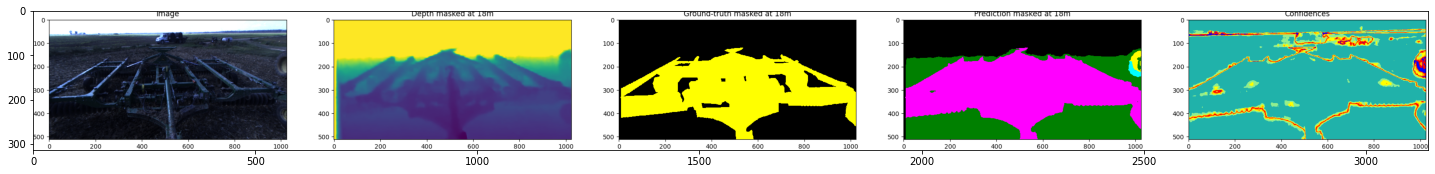

1 61e2be18aa81bf8e6e01b9af daytime rear-left large_object_false_negative true_negative_strict


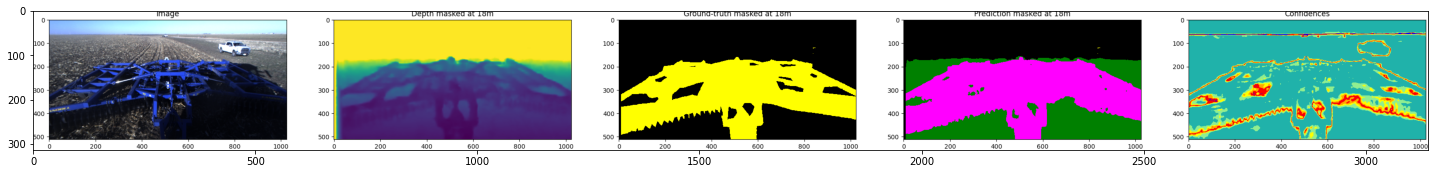

2 6166cf512418a384ef670a61 daytime front-left-left large_object_false_negative true_negative_strict


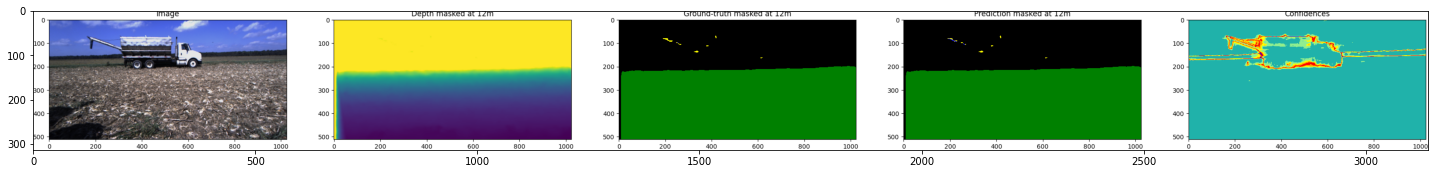

3 61ba97fa889691ebc48a31f5 nightime front-center-left large_object_false_negative false_positive_strict


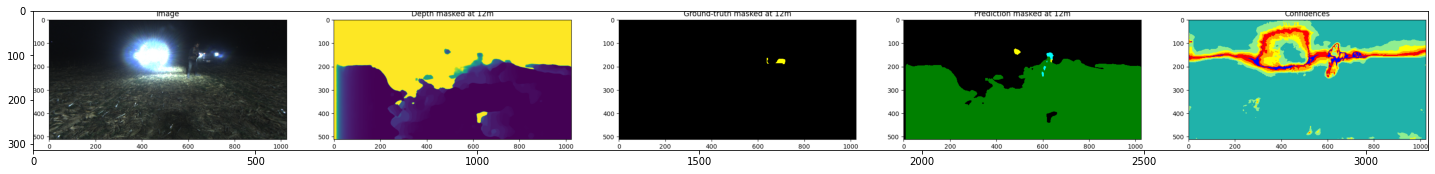

4 61670c65ed428d63112359ad nightime front-center-left large_object_false_negative false_positive_strict


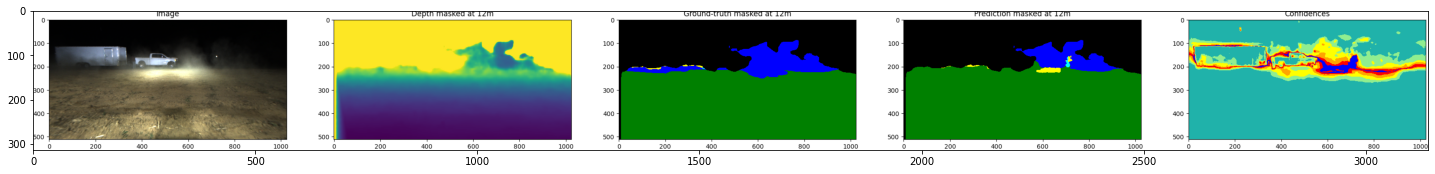

5 6166bc5897d32361f04c3868 dawn_dusk front-center-left large_object_false_negative true_negative_strict


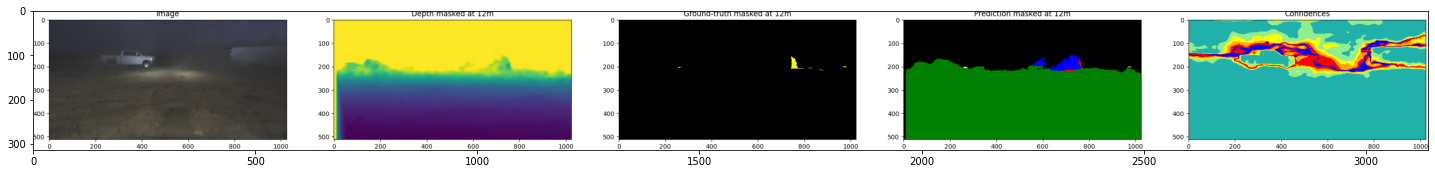

6 6166c64d8460bd58f441ab9d daytime rear-left large_object_false_negative false_positive_strict


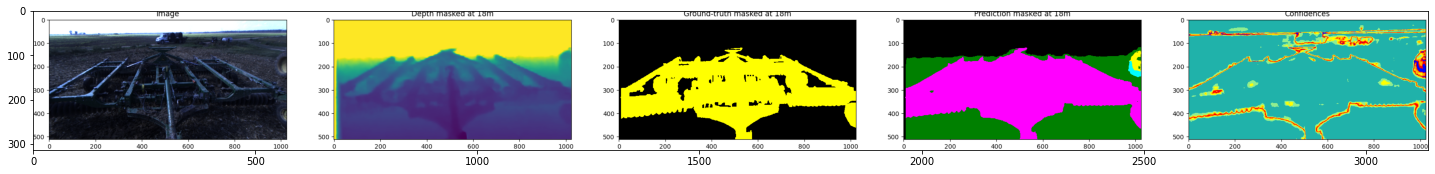

7 61e2bcde3779e1599eab6b95 daytime rear-left large_object_false_negative true_negative_strict


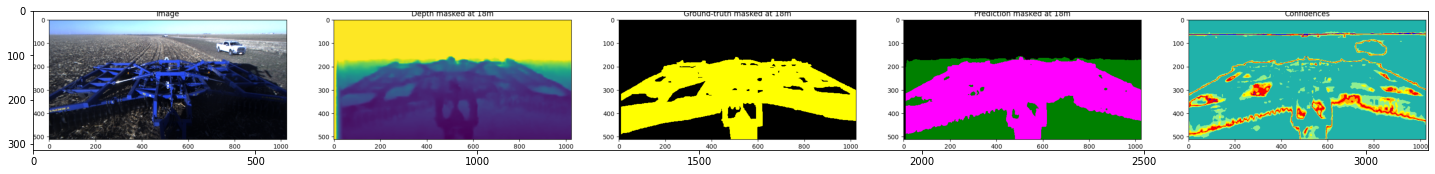

8 6166bc30ed428d631121580f dawn_dusk front-center-left large_object_false_negative true_negative_strict


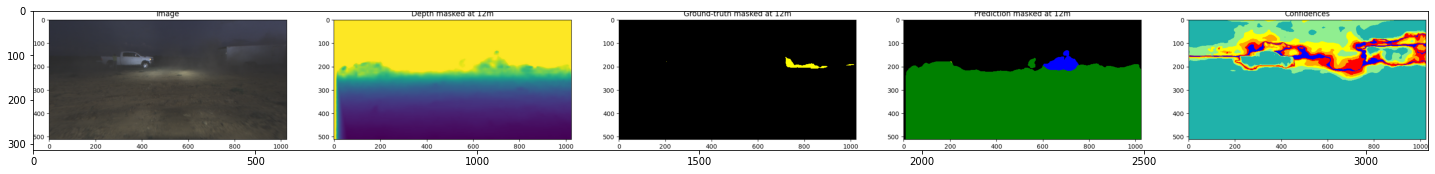

9 61eb829cc474d19dd1093750 dawn_dusk rear-left large_object_false_negative true_negative_strict


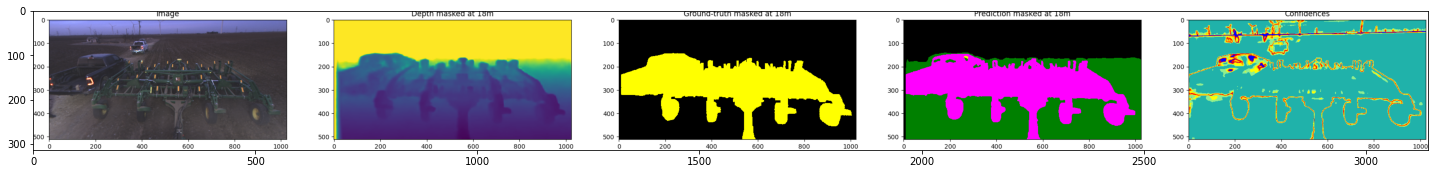

10 61baa4fe16121ea0cfddf5fa nightime front-center-left large_object_false_negative false_positive_strict


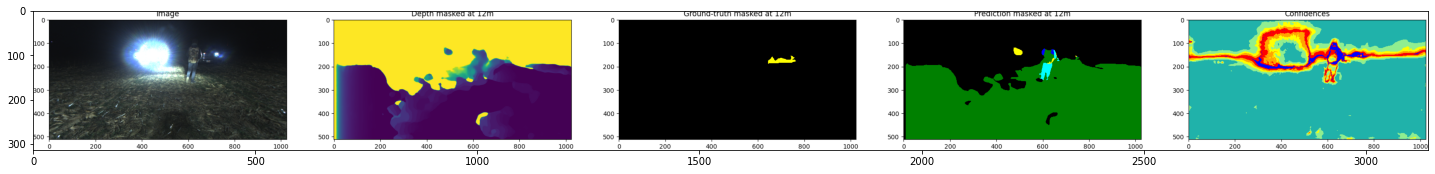

11 6166c1bf38c1ced8034a2fdc daytime front-left-left large_object_false_negative true_negative_strict


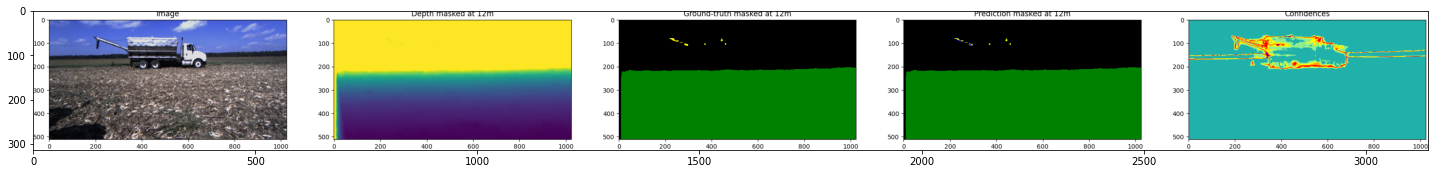

12 61c1a2827d515cfa9707b395 nightime front-left-left large_object_false_negative true_negative_strict


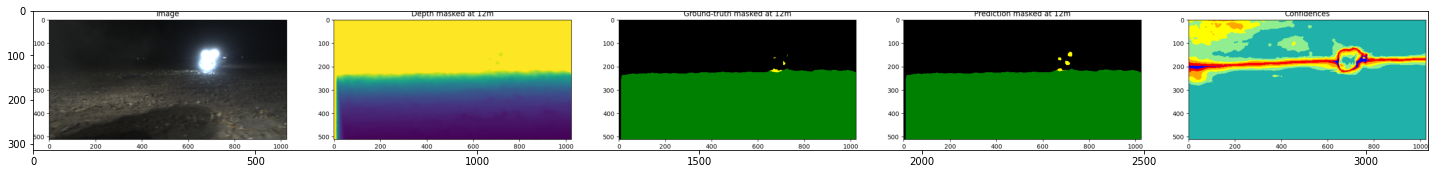

13 6166c4a538c1ced8034a4618 daytime rear-left large_object_false_negative false_positive_strict


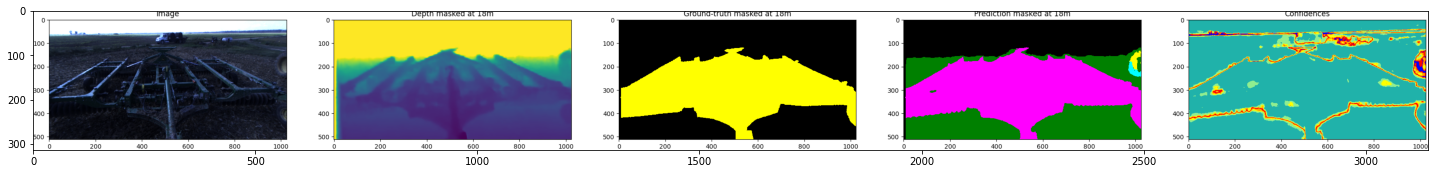

14 61eb41d31d4691b13a860378 dawn_dusk rear-left large_object_false_negative true_negative_strict


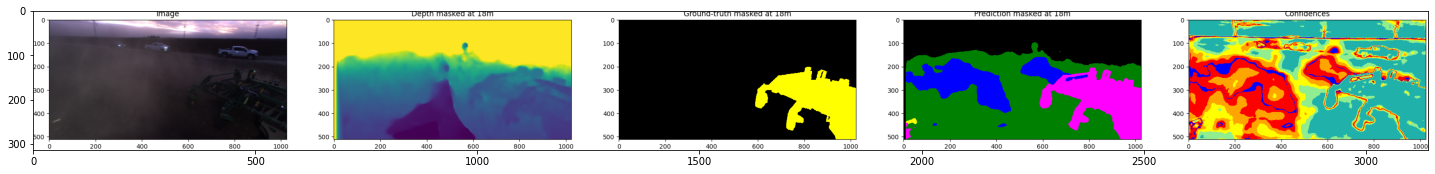

15 616636e218b73725be9d172d daytime front-center-left large_object_false_negative true_negative_strict


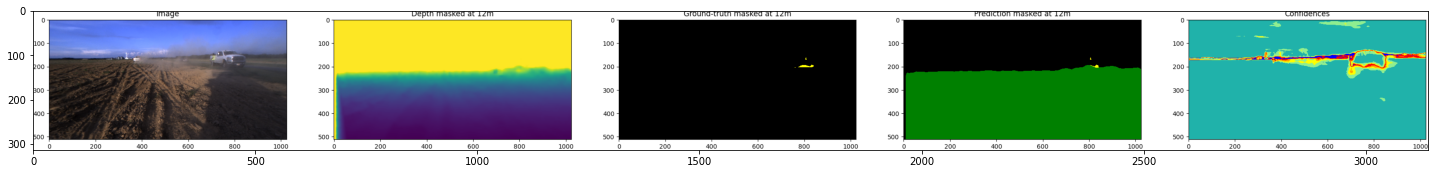

16 618b90ff15c8c0bc1d0389d0 daytime front-center-left large_object_false_negative true_negative_strict


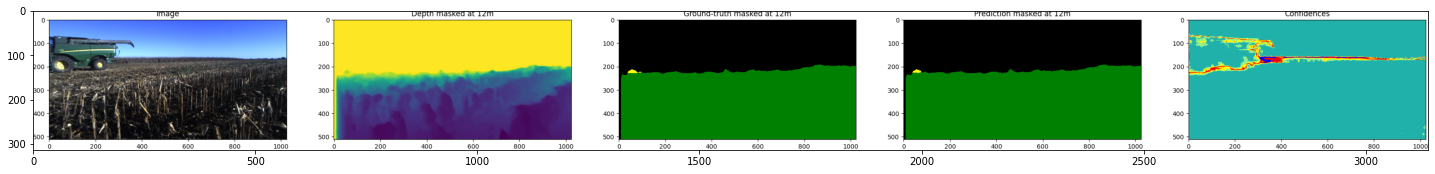

17 61b138ae14e30950bfecc48f daytime front-center-left large_object_false_negative true_negative_strict


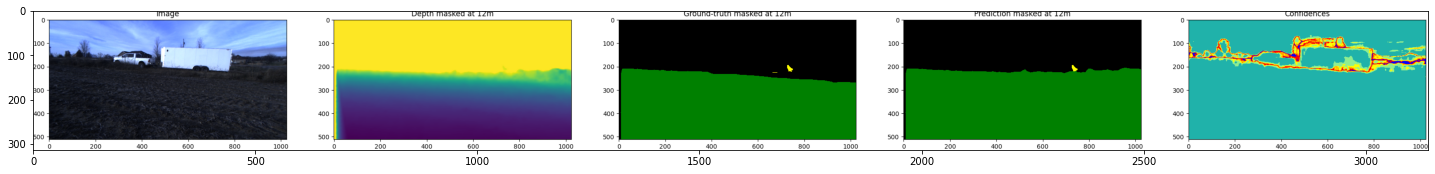

18 61c23f5d3cf3b48ae8ba6cc8 nightime rear-left large_object_false_negative true_negative_strict


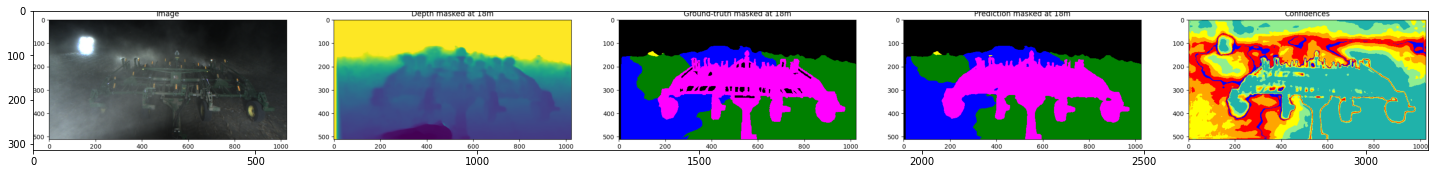

In [173]:
ids = df_fps['id']

# Play with this if you want to check IQ outputs as well
# bad_iq_ids = df_iq[df_iq['iq'] != 'good']['id']
# ids = df_fps[df_fps['id'].isin(bad_iq_ids)]['id']

print('Num fps: {}'.format(len(ids)))

ids = ids.sample(30) if len(ids) > 30 else ids

for i,id_ in enumerate(ids):
    path = os.path.join(results_dir, 'output_visualization', id_ + '.png')
    sample_df = df_states[df_states['id'] == id_].iloc[0]
    
    # link = os.path.join('http://10.10.15.41:8080/driveable_terrain_model/', exp ,'{}_{}'.format('{}{}'.format(dataset, suffix), exp_model), state, '{}.png'.format(id_))
    # print(link)
    
    # link = 'https://aletheia.brtws.com/images/{}'.format(id_)
    # print(link)
    
    print(i, id_, sample_df['operation_time'], sample_df['camera_location'], sample_df['state'], sample_df['additional_state'] if 'additional_state' in sample_df else None)
    
    if id_ in df_iq['id'].to_list():
        print('IQ:', df_iq[df_iq['id'] == id_]['iq'].iloc[0])
    
    img = plt.imread(path)
    plt.figure(figsize=(25, 120))
    plt.imshow(img)
    plt.show()